In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import gymnasium as gym
from copy import deepcopy
import torch
from tqdm import tqdm
%matplotlib inline

### Gymnasium

Reinforcement learning algorithms invovle many components as we have seen in the previous tutorial. 
We implemented several functions, and a few classes in order to build our final Deep Q-network algorithm. 
In general an RL algorithm is not created for one specific environment, but its a little unclear what we need to change with our 
Q-learning implementation in order to apply it to different problems. 

One way to get more generality is first of all to have a general class for environments, and rather 
than built that on our own we will make use of one commonly used in the RL community, namely [gymnasium](https://gymnasium.farama.org/). 
The class `gym.Env` is similar to a `BaseClass` in AGOX in that all implementation of environments inherit from it, one can 
thus create custom environment in that way, but `gym` also has many already implemented environments which is where we will start. 

We can make an environment, like so

In [2]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array', is_slippery=False)

As we discussed before, an essential part of a proper RL environment is the specification of a state $\mathcal{S}$ and action $\mathcal{A}$ space. 

Gym implements a space baseclass `gymnasium.spaces.Space`, this environment uses a `Discrete` space, as we can as such

In [3]:
env.action_space

Discrete(4)

This means it is a discrete space with four allowed actions, like what we worked with previously. 
Spaces have several convenient methods, a couple of examples

In [4]:
# Check if an action is part of the space. 
bools = [env.action_space.contains(a) for a in range(5)]
print(bools)

# Sample an action from the space.
a = env.action_space.sample()
print(a)

[True, True, True, True, False]
1


Of course we also need the state space, but in `gymnasium` it is not called the state space, but rather the observation space. 
This, I believe, is due to a difference in observability, a state is a complete description of everything happening in an environment - a state has the Markov property such that it contains everything knowable that can have an effect on the response of the environment. On the other hand an observation is a limited description, which for more difficult problems is more realistic to obtain. This [thread](https://ai.stackexchange.com/questions/5970/what-is-the-difference-between-an-observation-and-a-state-in-reinforcement-learn) has some useful answers for more information.

For us the distinction is not massively important currently. So lets just accept the difference in terminology and look at the observation space of this environment

In [5]:
env.observation_space

Discrete(16)

Again a discrete observation space. So what is this environment? 

So far (without having *illegally* looked at the [Frozen lake documentation](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)) what we know is that it is an 
environment with 4 discrete actions and 16 discrete states. 
Many of the environments in gym also have functionality to plot the environment, so we can try that

/home/machri/lustre/repositories/rl_week/env/rl_week/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


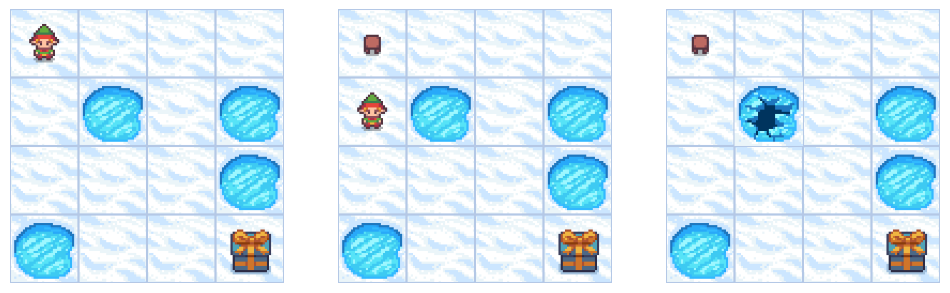

In [6]:
state = env.reset()
sz = 4
fig, ax = plt.subplots(1, 3, figsize=(3*sz, 1*sz))
img = ax[0].imshow(env.render())
_ = env.step(1)
img = ax[1].imshow(env.render())
_ = env.step(2)
img = ax[2].imshow(env.render())

for a in ax.flatten():
    a.axis('off')


So its a 4x4 grid with a big reward in the lower right corner, and a little dude in the upper right and several scary looking patches on the way. 

It is in fact the same environment as we were playing with before. 

The `step` function of the environment takes an action as input, propagates the internal state of the environment and returns this resulting state, a reward, whether the state is terminal or truncateed (e.g. if the maximum number of actions have been taken). 

In [7]:
state, reward, terminal, truncated, info = env.step(1)

print('State:', state)
print('Reward:', reward)
print('Terminal:', terminal)
print('Truncated:', truncated)

State: 5
Reward: 0
Terminal: True
Truncated: False


The `gymnasium` implementation of the environment uses a different representation of the state than the one we used, 
such that each state is described by a single integer which relates to the row and column coordinates through

$ s = 4 * \mathrm{row} + \mathrm{col} $

`gymnasium` has lots of neat functionality though, specifically for changing the environments through `wrappers`. 

We can wrap the environment with the following to get the same state space and representation as we worked with before: 

In [7]:
class TransformWrapper(gym.ObservationWrapper):

    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=4, shape=(4,4), dtype=int)

    def observation(self, state):
        row = state // 4
        col = state % 4
        return (row, col)

### Deep Q-network learning with `gymnasium`. 

Lets adapt our code from the previous notebook a little bit in order to use it with gymnasium. 

We will start by making our network class a little bit more general, and then implement a somewhat general DQN-learner. 

For the network what we need to do is to add arguments for the observation dimension and the action dimension. 

In [8]:
from typing import Any

class Q_network(torch.nn.Module):

    def __init__(self, observation_dim, action_dim, learning_rate=1e-3, 
                 hidden_dim=16, hidden_layers=1, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        
        self.input_layer = torch.nn.Linear(observation_dim, hidden_dim) # YOUR CODE HERE
        self.hidden_layers = []
        for hidden_layer in range(hidden_layers):
            layer = torch.nn.Linear(hidden_dim, hidden_dim) # YOUR CODE HERE.
            self.hidden_layers.append(layer)  # YOUR CODE HERE.
            self.add_module(f'hidden_layer_{hidden_layer}', layer) # This lets torch now about this layer. 
        self.output_layer = torch.nn.Linear(hidden_dim, action_dim) # YOUR CODE HERE. 

        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):

        x = self.input_layer(x)
        x = torch.relu(x)

        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = torch.relu(x)

        x = self.output_layer(x)

        return x


Similarly we need to change our `ExperienceReplay`-class to properly record observations for environments with different state-representations. 

In [9]:
class ExperienceReplay: 

    def __init__(self, observation_dim, size=100, batch_size=16):
        self.batch_size = batch_size
        self.obs_dim = observation_dim
        self.size = size
        self.clear()

    def add(self, state, action, reward, new_state, terminal):
        self.states[self.index] = torch.tensor(np.array(state))
        self.actions[self.index] = torch.tensor(action)
        self.rewards[self.index] = torch.tensor(reward)
        self.new_states[self.index] = torch.tensor(np.array(new_state))
        self.terminal[self.index] = torch.tensor(terminal)

        self.index += 1
        if self.index == self.size:
            self.index = 0

        if self.current_size < self.size:
            self.current_size += 1

    def get_batch(self):
        indices = np.random.randint(0, self.current_size, size=self.batch_size)
        return self.states[indices], self.actions[indices], self.rewards[indices], self.new_states[indices], self.terminal[indices]
    
    def clear(self):
        self.states = torch.tensor(np.zeros((self.size, self.obs_dim)), dtype=torch.float32) # YOUR CODE HERE
        self.new_states = torch.tensor(np.zeros((self.size, self.obs_dim)), dtype=torch.float32) # YOUR CODE HERE
        self.rewards = torch.tensor(np.zeros(self.size), dtype=torch.float32)
        self.actions = torch.tensor(np.zeros(self.size), dtype=torch.int32)
        self.terminal = torch.tensor(np.zeros(self.size), dtype=torch.bool)
        self.current_size = 0
        self.index = 0

Now lets write a Q-learner class that works for environments with discrete actions and 1D-array observations. 

In [10]:
class DQN_learner:

    def __init__(self, env, main_network, target_network, replay):
        self.env = env 
        self.main_network = main_network
        self.target_network = target_network
        self.copy_weights()
        self.replay = replay

    def learn(self, num_episodes=1000, gamma=0.90, train_interval=10, copy_interval=100, 
              epsilon=lambda x: 0.1):

        env = gym.wrappers.RecordEpisodeStatistics(self.env, deque_size=num_episodes)

        step_count = 0
        for episode in tqdm(range(num_episodes)):

            state, _ = env.reset()
            terminal = False
            truncated = False

            while not terminal and not truncated:

                # Choose action
                # If random number is less than epsilon, then select a random action
                # Else select according to the Q-values. When selecting according to Q-values,
                if np.random.rand() < epsilon(episode):
                    action = env.action_space.sample()
                else:
                    state_tensor = torch.tensor(np.array([state], dtype=np.float32))
                    with torch.no_grad():
                        Q = self.main_network(state_tensor).detach().numpy()
                        action = np.argmax(Q)

                # Take action by calling env.step
                next_state, reward, terminal, truncated, info = env.step(action)
                step_count += 1

                # Add to replay buffer
                self.replay.add(state, action, reward, next_state, terminal)

                # Train the network. 
                if step_count % train_interval == 0 and step_count > 200:
                    self.train_network(gamma=gamma)

                # Copy weights from the main network to the target network
                if step_count % copy_interval == 0:
                    self.copy_weights()        

                # Update the state. 
                state = next_state

        return env.return_queue, env.length_queue

    def train_network(self, gamma=0.90):
        # Get a batch of data from the replay buffer
        states, actions, rewards, new_states, terminal = self.replay.get_batch()
        batch_size = len(states)

        # Calculate the Q-values for the current state
        Q = self.main_network(states)

        # Calculate the Q-values for the next state
        with torch.no_grad():
            Q_next = self.target_network(new_states).detach()
            Q_next_max = torch.max(Q_next, dim=1).values

        # Calculate the TD-target - Remember to use the terminal states such that 
        # the target for terminal states is just the reward. 
        # torch.logical_not is useful here. 
        td_target = rewards + torch.logical_not(terminal) * gamma * Q_next_max

        # Calculate the loss
        Q = Q[torch.arange(batch_size), actions]
        loss = torch.nn.functional.mse_loss(Q, td_target)

        # Backpropagate the loss
        loss.backward()
        self.main_network.optimizer.step()
        self.main_network.optimizer.zero_grad()

    def test(self, N=100):

        env = gym.wrappers.RecordEpisodeStatistics(self.env, deque_size=N)
        print('Running test episodes')
        for episode in tqdm(range(N)):

            state, _ = env.reset()
            terminal = False
            truncated = False

            while not terminal and not truncated:

                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    Q = self.main_network(state_tensor)
                    action = torch.argmax(Q).item()

                # Take action by calling env.step
                next_state, reward, terminal, truncated, info = env.step(action)

                # Update the state. 
                state = next_state

        return np.array(env.return_queue).flatten(), np.array(env.length_queue).flatten()

    def copy_weights(self):
        self.target_network.load_state_dict(deepcopy(self.main_network.state_dict()))

Now we're ready to test our DQN-learner on Frozenlake, I suggest you try with and without the TransformWrapper, to confirm that your network implementation and 
replay both are capable of having a different sized representation for the state. 

Note, in my experience it is more difficult to train the network with the default gymansium representation of numbers in [0, 15], I found that having more hidden layers alleviates this issue. 

In [15]:

# Can either use the wrapped environment or the original one
# This choice influences the way the state is represented and thus 
# the dimension of the observation. 
#env = TransformWrapper(gym.make('FrozenLake-v1', is_slippery=False))
env = gym.make('FrozenLake-v1', is_slippery=False)

# Set these according to the environment
obs_dim = 1
n_actions = 4

# Choose network settings: 
network_settings = {'hidden_dim': 16, 'learning_rate': 1e-3, 'hidden_layers':1}
main_network = Q_network(observation_dim=obs_dim, action_dim=n_actions, **network_settings)
target_network = Q_network(observation_dim=obs_dim, action_dim=n_actions, **network_settings)

# Setup a experience replay. 
replay = ExperienceReplay(observation_dim=obs_dim, size=1000, batch_size=64)

# Make a learner & train it
learner = DQN_learner(env, main_network, target_network, replay)
num_episodes = 1000
epsilon = lambda i: 0.1
returns, lengths = learner.learn(num_episodes=num_episodes, gamma=0.90, train_interval=1, copy_interval=100, epsilon=epsilon)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/machri/lustre/repositories/rl_week/env/rl_week/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 1000/1000 [01:37<00:00, 10.23it/s]


Again we can plot to see if we get what we expect. 

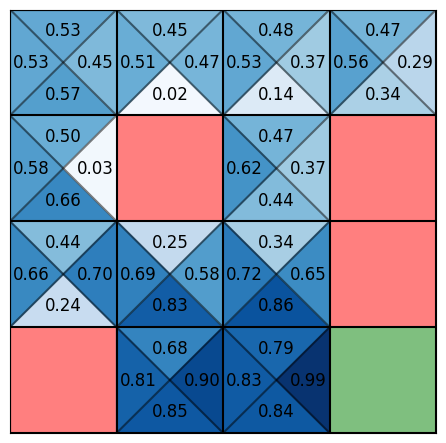

In [16]:
from rlweek.utils.plot_qvalues import plot_qvalues
# Make a table of its predictions: 
Q_table_nn = np.zeros((4, 4, 4), dtype=np.float64)

if obs_dim == 2:
    for row in range(4):
        for col in range(4):
            state = (row, col)
            state_tensor = torch.tensor([state[0], state[1]], dtype=torch.float32)
            Q_table_nn[row, col] = main_network.forward(state_tensor).detach().numpy()
elif obs_dim == 1:
    for state in range(16):
        row, col = state // 4, state % 4
        state_tensor = torch.tensor([state], dtype=torch.float32)
        Q_table_nn[row, col] = main_network.forward(state_tensor).detach().numpy()


sz = 5.5
fig, ax = plt.subplots(1, 1, figsize=(1*sz, 1*sz))
plot_qvalues(ax, Q_table_nn.reshape(16, 4), desc=env.unwrapped.desc) # You can set desc=None to see the Q-values without the holes/goal colors overlayed. 


### Other environments. 

Now that we have a DQN-learner, lets try it on different environments. 

A consequence of using a neural network rather than a table that we have not discussed so far, is that we are able to handle environments 
with continuous observation spaces. An environment with a continuous observation space from `gymnasium` is [Cart Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/). So we will try that! 

Look at the documentation, or play around with `env.observation_space` and `env.action_space` to figure out how this environment works. 

In [23]:
# Make the cartpole environment. 
env = gym.make('CartPole-v1')

# Set the action and observation dimensions: 
obs_dim = 4
n_actions = 2

# Set the network settings:
network_settings = {'hidden_dim': 64, 'learning_rate': 1e-3, 'hidden_layers':1}
main_network = Q_network(observation_dim=obs_dim, action_dim=n_actions, **network_settings)
target_network = Q_network(observation_dim=obs_dim, action_dim=n_actions, **network_settings)
replay = ExperienceReplay(observation_dim=obs_dim, size=1000, batch_size=32)

# Make a learner: 
learner = DQN_learner(env, main_network, target_network, replay)
num_episodes = 250
epsilon = lambda i: 1 - (i / num_episodes) * 0.9
#epsilon = lambda i: 0.1
returns, lengths = learner.learn(num_episodes=num_episodes, gamma=0.99, train_interval=1, copy_interval=100, epsilon=epsilon)

test_returns, test_lengths = learner.test(N=100)

100%|██████████| 250/250 [10:12<00:00,  2.45s/it]


Running test episodes


100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


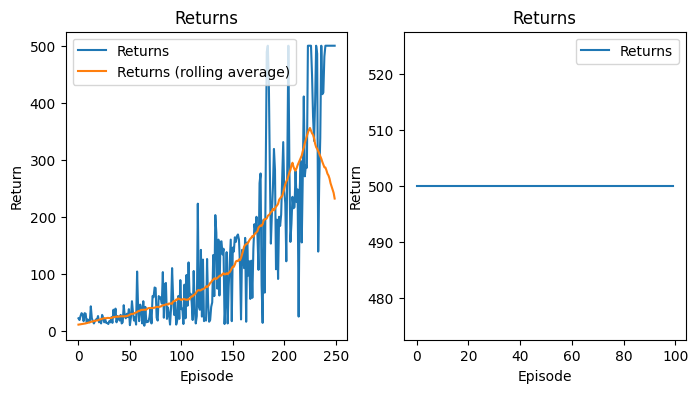

In [24]:
def rolling_average(x, N):
    return np.convolve(np.array(x).flatten(), np.ones((N,))/N, mode='same')

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(returns, label='Returns')
ax[0].plot(rolling_average(returns, 50), label='Returns (rolling average)')
ax[0].set_title('Returns')
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Return')
ax[0].legend()

ax[1].plot(test_returns, label='Returns')
ax[1].set_title('Returns')
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Return')
ax[1].legend()




The maximum return for this environment is 500, and an agent that can consistently achieve that with $\epsilon=0$ can be trained in 500 episodes. However it is sensitive to hyperparameters, I found $\gamma$ to be very important, best results with $\gamma=0.99$, and also depends on the initial seed, so a trying a few times may be necessary. 

You can compare your results to these [resuls](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) from the PyTorch documentation. 
That tutorial also includes several tricks that may help the effiency of the our learner
- Huber loss (Less sensistive to outliers)
- Gradient clipping (Reducing large gradients)
- Soft update of the target network, rather that the 'hard' copying than we have been doing. 
- Different $\epsilon$-schedule. 
- Hyperparameter settings. 

For CartPole your learner should be able to achieve perfect play without any of these though. 

#### Optional exercise: The Double Q-learning 'trick'. 

Reinforcement learning is a field filled with tricks, it can be difficult to distinguish between when something is a trick and when something is more of a proper method. 
For example, the replay buffer and use of two networks is kind of a trick - but are also pretty much neccesary to make things work. 
So we need to be able to utilize such tricks, so as an exercise we will implemenet a final trick for our Q-learning algorithm. 

Remember the temporal difference target: 

$Q^{main}(s_t, a_t) \leftarrow r(s_t, a_t) + \gamma \mathrm{max}_{a^*} \ Q^{target}(s_{t+1}, a^*)$

The Q-values are noisy, we don't know them exactly (unsurprisingly, given this is an equation for training). Especially the $\mathrm{max}$ operation is vulnerable to noise and bias, which might make us train towards unreaslisticly high Q-values. A trick to avoid this is so called Double Q-learning, in words what we want to do is: 

1. Find the action of the next state using our main network $a^m = \mathrm{argmax} Q^{main}(s_{t+1}, a^*)$. 
2. Use that action to calculate the Q-value from the target network. 

Putting that together we get

$Q^{main}(s_t, a_t) \leftarrow r(s_t, a_t) + \gamma Q^{target}(s_{t+1}, \mathrm{argmax} \ Q^{main}(s_{t+1}, a^*))$

Change the `train` function to implement this. 

#### Note: 
If you want to play around more with Q-learning you may want to move out of the notebook and play around with a script and run with GPU. 
The script in `rlweek/utils/dqn_learner.py` can be a starting point to do so. 

#### Optional exercise: 

Try the DQN-learner on the [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) environment. 

### Conclusion

We have implemented a DQN-learner that is capable of learning several environments with no 
user input about the specific environments, all we have to do guess appropriate hyperparameters and 
the agent is able to master these environments on its own! That is pretty cool! 

Take-aways: 
- The Bellman equation encodes a powerful self-consistency that allows for learning strategies for diffiuclt problems. 
- With a few tricks the tabular strategy can be changed for a neural network based approach. 
- Using a network lets us tackle environments with continious observation spaces. 
- `gymnasium` provides easy to use, customizable environments with a consistent API. 

However, this type of deep reinforcement learning lives on the intersection of two-fiels; deep learning and reinforcement learning - both of which are full of tricks and full of hyperparameters that often need to be chosen appropriately as the algorithms are brittle to these choices. 